In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.spatial.distance import cdist

In [2]:
# Classes to collect and cluster the data
class BaseCluster:
    """
    class to represent each initial data point
    """
    def __init__(self, datapoint, cluster_name):
        # if the data has only one dimension, add one dimension. k is the number of features of the data point
        # (k,) --> (1,k)  
        if len(datapoint.shape ) == 1:
            self.data = np.expand_dims(datapoint,axis=0) 
        else:
            self.data = datapoint
        self.cluster_name = cluster_name     # name of cluster : will be used to order data in the dendrogram
        self.plotline_yaxis_start_line = 0   # start of line in dendrogram, y axis                   
        self.plotline_yaxis_end_line = None  # end of line in dendrogram, y axis   
        self.number_baseclusters = 1         # number of baseclusters in it, 1 for each basecluster    
        self.xvalue = None                   # x coordinated in dendrogram, will be populated in after clustering is complete
    
    def set_plotline_yaxis_end_line(self, distance):
        # once two clusters are merged , the plotline_yaxis_end_line can be filled
        self.plotline_yaxis_end_line = distance       

class MixCluster:
    """ 
    Class to represent clusters mergers:
     -  BaseCluster + BaseCluster
     -  MixCluster + BaseCluster
     -  MixCluster + MixCluster 
    """
    def __init__(self, cluster1, cluster2, distance):
        self.rightcluster = cluster1       # clusters that have merged in the current MixCluster
        self.leftcluster = cluster2        # clusters that have merged in the current MixCluster  
        self.cluster_name = cluster1.cluster_name +'-' + cluster2.cluster_name # concatenate the name of the clusters (useful to arrange BaseCluster on dendrogram)
        self.plotline_yaxis_end_line = None # end of line in dendrogram, y axis   
        self.xvalue = None                  # x coordinated in dendrogram, will be populated in after clustering is complete

        cluster1.set_plotline_yaxis_end_line(distance) # update the end of line in dendrogram in lower clusters (the right one belonging to current MixCluster)
        cluster2.set_plotline_yaxis_end_line(distance) # update the end of line in dendrogram in lower clusters (the left one belonging to current MixCluster)
        self.plotline_yaxis_start_line = distance      # start of line in dendrogram for current mixcluster, y axis          
        self.number_baseclusters = cluster1.number_baseclusters + cluster2.number_baseclusters  # how many baseclusters are inside the current MixCluster
        self.data = np.concatenate([cluster1.data, cluster2.data],axis=0)    # The current MixCluster will contain the data of the clusters it contains

    def set_plotline_yaxis_end_line(self, distance):
        # once two clusters are merged , the plotline_yaxis_end_line can be filled
        self.plotline_yaxis_end_line = distance


# function to calculate the distance clusters (MixClusters or BaseClusters)
def calculate_distance(cluster1, cluster2, 
                       metric = 'euclidean', 
                       linkage = 'single'):
    
    assert linkage in ['single', 'complete', 'average', 'ward'], "linkage not valid"
    assert metric in ['euclidean', 'cityblock', 'cosine', 'ward', None], "not implemented "  # cityblock is equal to Manhattan distance 

    if linkage == 'ward':
        center = np.mean(np.concatenate([ cluster1.data , cluster2.data ]), axis= 0)
        sum2 = np.sum( np.sum((cluster1.data - center ) **2) + np.sum((cluster2.data - center ) **2))
        return np.round(sum2,6)
    
    # compute the distance between the two clusters
    distances = cdist(cluster1.data, cluster2.data, metric= metric)
    if linkage== 'single': # return the minumum distance 
        d =  np.min(distances)
    
    elif linkage== 'complete': # return the maximum distance 
        d =  np.max(distances)
    
    elif linkage== 'average':   # return the mean distance 
        d =  np.mean(distances) 
    
    return np.round(d,6)
        
# generate distance matrix 
def generate_distance_matrix(clusters_list, 
                             metric, 
                             linkage):
    distances = np.zeros(shape=(len(clusters_list), len(clusters_list)))
    for r in range(distances.shape[0]):
        for c in range(distances.shape[1]):
            if r == c :
                # set the distance on the diagnonal to a very large number 
                distances[r,c] = float('1e10')
            else:                
                distances[r,c] = calculate_distance(cluster1=clusters_list[r], cluster2 = clusters_list[c], metric = metric, linkage = linkage)

    return distances

In [3]:
# function that clusters all data together
def clustering(data, metric = 'euclidean', linkage ='single'):
    """   
    It clusters all data together and returns a MixCluster that 
    contains MixCluster and BaseClusters in a hierarchical manner
    
    """
    # create a BaseCluster for each data point
    baseclusters = [BaseCluster(datapoint=data[i], cluster_name= "Basecluster_" +str(i)) for i in range(data.shape[0])]

    while True:

        # generate the distance matrix
        distances = generate_distance_matrix(clusters_list = baseclusters, metric=metric ,  linkage=linkage)

        # find min distance and identify the closest clusters that need to be merged
        min_distance = np.min(distances)

        # Get the indices of the min_distance --> the two clusters to merge
        min_indices = np.where(distances == min_distance)
        c,r = min_indices[0][:2]

        # Merge cluster into a new cluster MixCluster
        new_cluster = MixCluster(cluster1=baseclusters[c], cluster2=baseclusters[r], distance= min_distance)

        # Remove the two clusters just merged and add the new merged one
        baseclusters.pop(max(c,r))
        baseclusters.pop(min(c,r))
        baseclusters.append(new_cluster)

        # when only one cluster is left, all data has been clustered, break the loop
        if len(baseclusters)==1 :
            break

    return baseclusters[0] 


## Generate some data

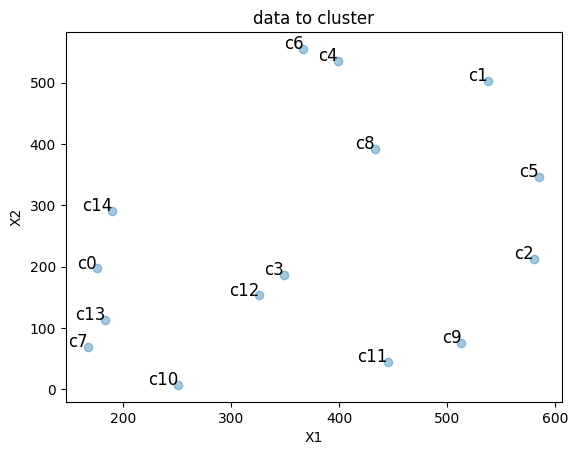

In [4]:
# generate and visualiaze some random data 
np.random.seed(7)
data = np.random.randint(low = 1, high= 600 , size=(15,2))

# plot the data
plt.scatter(data[:,0], data[:,1], alpha= 0.4)
names = ["c" + str(i) for i in range(data.shape[0])]
for i in range(data.shape[0]):
    plt.text(data[i,0], data[i,1], names[i], fontsize=12, ha='right')

plt.xlabel('X1')
plt.ylabel('X2')
plt.title('data to cluster')
plt.show()

## Cluster the data 

In [5]:
# cluster the data 
# the final cluster is a MixCluster object that contains MixClusters and BaseClusters
master_cluster =  clustering(data=data , 
                             metric='euclidean', 
                             linkage= 'average')

In [6]:
# inspect the name of master_cluster
master_cluster.cluster_name # the name of the cluster shows how to organize the data (base clusters) on the x axis of the dendrogram

'Basecluster_4-Basecluster_6-Basecluster_1-Basecluster_8-Basecluster_10-Basecluster_7-Basecluster_13-Basecluster_3-Basecluster_12-Basecluster_0-Basecluster_14-Basecluster_9-Basecluster_11-Basecluster_2-Basecluster_5'

In [7]:
# inspect the immediate RIGHT cluster of the final cluster which for this specific data turned out to be a MixCluster  
print('right cluster type:',master_cluster.rightcluster) 
print('right cluster name:',master_cluster.rightcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.rightcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.rightcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.rightcluster.xvalue) 

right cluster type: <__main__.MixCluster object at 0x0000017530DA0950>
right cluster name: Basecluster_4-Basecluster_6-Basecluster_1-Basecluster_8
right cluster plotline_yaxis_start_line: 161.35243
right cluster plotline_yaxis_end_line: 396.325049
right cluster xvalue: None


In [8]:
# inspect the immediate LEFT cluster of the final cluster which for this specific data turned out to be a MixCluster  
print('right cluster type:',master_cluster.leftcluster) 
print('right cluster name:',master_cluster.leftcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.leftcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.leftcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.leftcluster.xvalue) 

right cluster type: <__main__.MixCluster object at 0x0000017530DA0A10>
right cluster name: Basecluster_10-Basecluster_7-Basecluster_13-Basecluster_3-Basecluster_12-Basecluster_0-Basecluster_14-Basecluster_9-Basecluster_11-Basecluster_2-Basecluster_5
right cluster plotline_yaxis_start_line: 330.098407
right cluster plotline_yaxis_end_line: 396.325049
right cluster xvalue: None


In [9]:
# function that adds the x coordinates of the lines in the dendrogram for each cluster
def complete_xcoordinates(clustered_data):

    # get the name of the main cluster and split it to get the arrangement of the datapoints on the x axis
    xaxis_sequence = clustered_data.cluster_name.split('-')

    def add_x(parent):

        # get the right and left clusters of the current cluster
        child_right = parent.rightcluster
        child_left = parent.leftcluster

        # if for both child clusters the xvalue is known, the current xvalue is equal to the their mean
        if child_right.xvalue != None and child_left.xvalue != None:
            parent.xvalue = np.mean([child_right.xvalue, child_left.xvalue])
        
        # otherwise move one level lower
        else:
            for clu in [child_right, child_left]:
                # if the cluster is a BaseCluster xvalue is equal to the position (index) of that cluster in xaxis_sequence
                if isinstance(clu , BaseCluster):
                    if clu.xvalue == None:
                        clu.xvalue = xaxis_sequence.index(clu.cluster_name)

                # else the cluster is a MixCluster, thus repeat 
                else:
                    add_x(clu)
    
    while clustered_data.xvalue == None:
        add_x(clustered_data)

    return clustered_data

# add x coordinates to the clustered data 
clustered_data = complete_xcoordinates(clustered_data = master_cluster)

In [10]:
#  Inspect again the uppermost right and left cluster --> note the xvalues are filled now
print('RIGTH cluster')
print('right cluster type:', master_cluster.rightcluster) 
print('right cluster name:', master_cluster.rightcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.rightcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.rightcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.rightcluster.xvalue)  # note that xvalue is now populated 

print('LEFT cluster')
print('right cluster type:',master_cluster.leftcluster) 
print('right cluster name:',master_cluster.leftcluster.cluster_name) 
print('right cluster plotline_yaxis_start_line:',master_cluster.leftcluster.plotline_yaxis_start_line) 
print('right cluster plotline_yaxis_end_line:',master_cluster.leftcluster.plotline_yaxis_end_line) 
print('right cluster xvalue:',master_cluster.leftcluster.xvalue) # note that xvalue is now populated 

RIGTH cluster
right cluster type: <__main__.MixCluster object at 0x0000017530DA0950>
right cluster name: Basecluster_4-Basecluster_6-Basecluster_1-Basecluster_8
right cluster plotline_yaxis_start_line: 161.35243
right cluster plotline_yaxis_end_line: 396.325049
right cluster xvalue: 1.5
LEFT cluster
right cluster type: <__main__.MixCluster object at 0x0000017530DA0A10>
right cluster name: Basecluster_10-Basecluster_7-Basecluster_13-Basecluster_3-Basecluster_12-Basecluster_0-Basecluster_14-Basecluster_9-Basecluster_11-Basecluster_2-Basecluster_5
right cluster plotline_yaxis_start_line: 330.098407
right cluster plotline_yaxis_end_line: 396.325049
right cluster xvalue: 9.5625


# Plot the dendrogram

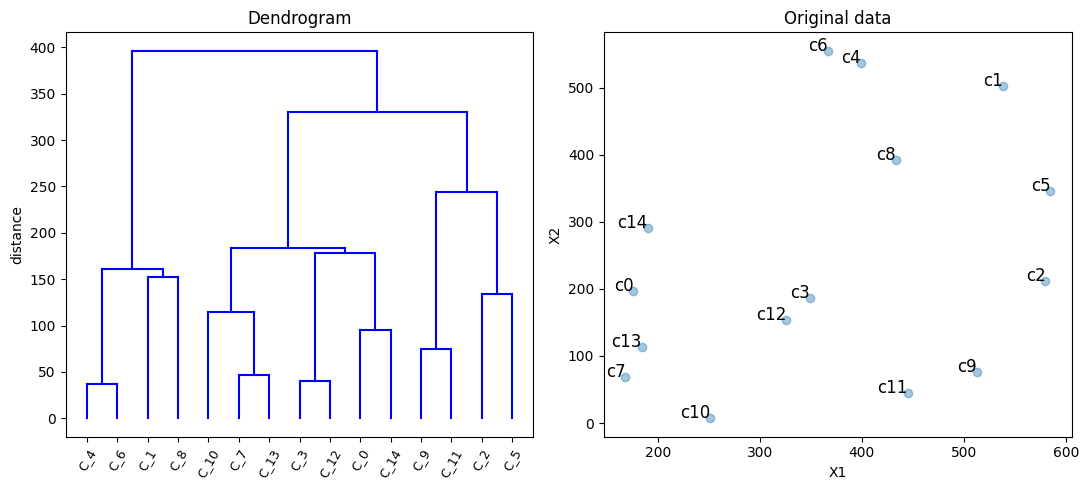

In [11]:
# function to plot the dendrogram
def plot_dendrogram(clusterwithcoordinates,figsize = (8,8)):

    plt.figure(figsize= figsize)
    plt.subplot(1,2,1)
    plt.title('Dendrogram')
    
    # plot the top horizontal line, connecting the uppermost two clusters.
    plt.plot([clusterwithcoordinates.rightcluster.xvalue, clusterwithcoordinates.leftcluster.xvalue ],
             [clusterwithcoordinates.plotline_yaxis_start_line, clusterwithcoordinates.plotline_yaxis_start_line ] ,color = 'blue')

    #print(xlines)
    def add_line(parent):
        #print(xlines)
        child_right = parent.rightcluster
        child_left = parent.leftcluster
        for clu in [child_right, child_left]:
            #print(xlines)
            plt.plot([clu.xvalue, clu.xvalue ],[clu.plotline_yaxis_start_line, clu.plotline_yaxis_end_line ] ,color = 'blue')
            if isinstance(clu, MixCluster):
                plt.plot([clu.rightcluster.xvalue, clu.leftcluster.xvalue ],[clu.plotline_yaxis_start_line, clu.plotline_yaxis_start_line ] ,color = 'blue')
            if isinstance(clu, MixCluster):
                add_line(clu)

    add_line(clusterwithcoordinates)
    labels = [i.replace('Basecluster_', 'C_') for i in clusterwithcoordinates.cluster_name.split('-')]
    plt.xticks(ticks= range(len(labels)), labels= labels , rotation =60, ha = 'center')
    plt.tick_params(axis='x', labelsize= 9)
    plt.ylabel('distance')

    #plot the original data:
    plt.subplot(1,2,2)

    plt.scatter(data[:,0], data[:,1], alpha= 0.4)
    names = ["c" + str(i) for i in range(data.shape[0])]
    for i in range(data.shape[0]):
        plt.text(data[i,0], data[i,1], names[i], fontsize=12, ha='right', alpha = 1,)

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Original data')
    plt.tight_layout()
    plt.show()

# plot the dendrogram
plot_dendrogram(master_cluster, figsize = (11,5))



# Repeat the clustering using ward distance

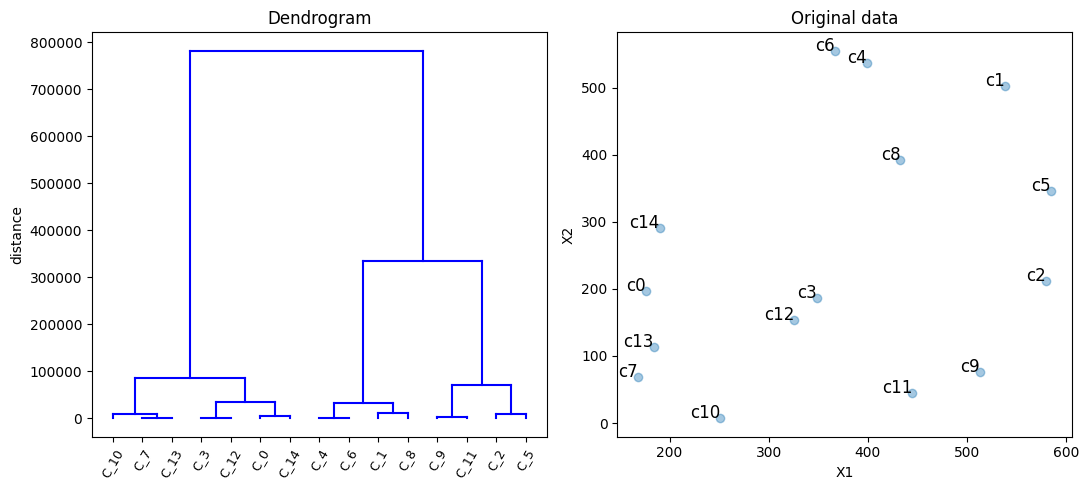

In [12]:
# cluster the data
master_cluster =  clustering(data=data , 
                             metric= None, 
                             linkage= 'ward')

# add x coordinates for each cluster
clustered_data = complete_xcoordinates(clustered_data = master_cluster)

# display the result
plot_dendrogram(master_cluster, figsize = (11,5))